In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric rdkit -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

In [2]:
import torch
import torch_geometric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
logp_dataset = pd.read_csv('Final MFLOGP Dataset.csv')

logp_dataset.head()

,Names,Formula,CAS No,SMILES,Reference,Exp logp,C,H,N,O,S,P,F,Cl,Br,I,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,formaldehyde,C1H2O1,000050-00-0,C=O,"hansch,c et al. (1995)",0.35,1,2,0,1,0,0,0,0,0,0,NaN,2,90.0
1,"9-fluoro-11,17-dihydroxy-17-(2-hydroxyacetyl)-...",C22H29F1O5,000378-44-9,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,"hansch,c et al. (1995)",1.94,22,29,0,5,0,0,1,0,0,0,NaN,28,NaN
2,"[2-(11,17-dihydroxy-10,13-dimethyl-3-oxo-2,6,7...",C23H32O6,000050-03-3,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,"hansch,c et al. (1995)",2.19,23,32,0,6,0,0,0,0,0,0,NaN,29,NaN
3,"[2-(17-hydroxy-10,13-dimethyl-3,11-dioxo-1,2,6...",C23H30O6,000050-04-4,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,"hansch,c et al. (1995)",2.10,23,30,0,6,0,0,0,0,0,0,NaN,29,NaN
4,"5-ethyl-5-phenyl-1,3-diazinane-2,4,6-trione",C12H12N2O3,000050-06-6,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2,"hansch,c et al. (1995)",1.47,12,12,2,3,0,0,0,0,0,0,NaN,17,NaN


In [4]:
smiles_sample = logp_dataset[logp_dataset['Names'] == 'picloram'].iloc[0]['SMILES']

graph_sample = torch_geometric.utils.smiles.from_smiles(smiles_sample)

graph_sample

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='Nc1c(Cl)c(Cl)nc(C(O)=O)c1Cl')

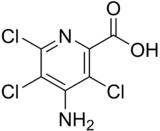

In [5]:
# Atomic n, chirality, degree, formal charge, n hydrogens, n radical electrons, hybridization, aromatic?, in ring?

graph_sample.x

tensor([[ 7,  0,  3,  5,  2,  0,  3,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [17,  0,  1,  5,  0,  0,  4,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [17,  0,  1,  5,  0,  0,  4,  0,  0],
        [ 7,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  3,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [17,  0,  1,  5,  0,  0,  4,  0,  0]])

In [6]:
# Bond type, stereo, conjugated?

graph_sample.edge_attr

tensor([[ 1,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0]])

In [7]:
all_atoms_counts = {}

for smiles in logp_dataset['SMILES']:
  smiles_graph = torch_geometric.utils.smiles.from_smiles(smiles)

  graph_atoms = smiles_graph.x[:,0]

  atoms, counts = np.unique(graph_atoms, return_counts=True)

  for i, atom in enumerate(atoms):
    if atom not in all_atoms_counts:
      all_atoms_counts[atom] = counts[i]
    else:
      all_atoms_counts[atom] += counts[i]
    
all_atoms_counts

{6: 197242,
 8: 36192,
 9: 2992,
 7: 23586,
 15: 450,
 17: 6369,
 16: 3274,
 53: 265,
 35: 938,
 1: 19,
 14: 1,
 50: 1,
 74: 11,
 11: 5,
 19: 1}

In [8]:
no_unusual_atoms = []

for smiles in logp_dataset['SMILES']:
  smiles_graph = torch_geometric.utils.smiles.from_smiles(smiles)

  graph_atoms = smiles_graph.x[:,0]

  atoms = np.unique(graph_atoms)

  keep_molecule = True

  for atom in atoms:
    if atom not in [6, 8, 9, 7, 15, 17, 16, 53, 35]:
      keep_molecule = False
      break
  
  if keep_molecule:
    no_unusual_atoms.append(True)
  else:
    no_unusual_atoms.append(False)

logp_dataset['no_unusual_atoms'] = no_unusual_atoms

len(logp_dataset)

18091

In [9]:
regular_atoms_dataset = logp_dataset[logp_dataset['no_unusual_atoms'] == True]

len(regular_atoms_dataset)

18070

In [10]:
mol_atom_attrs = []
mol_bond_attrs = []

for smiles in logp_dataset['SMILES']:
  smiles_graph = torch_geometric.utils.smiles.from_smiles(smiles)

  mol_atom_attrs.append(graph_sample.x)

  mol_bond_attrs.append(graph_sample.edge_attr)

atomic n
(array([ 6,  7,  8, 17]), array([108546,  36182,  36182,  54273]))


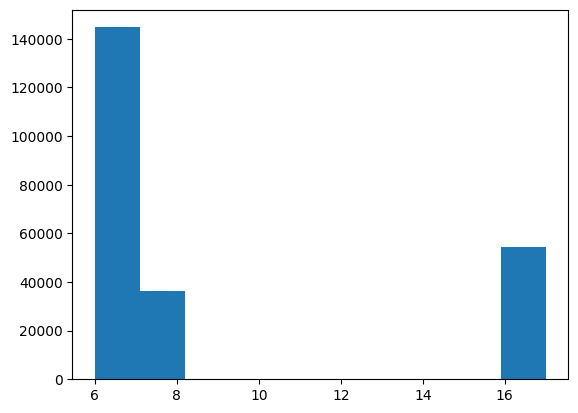

chirality
(array([0]), array([235183]))


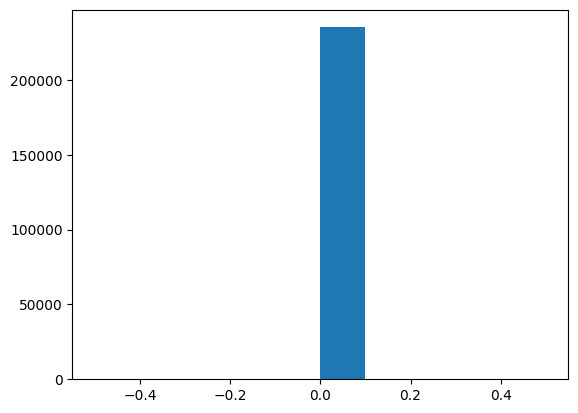

degree
(array([1, 2, 3]), array([ 72364,  36182, 126637]))


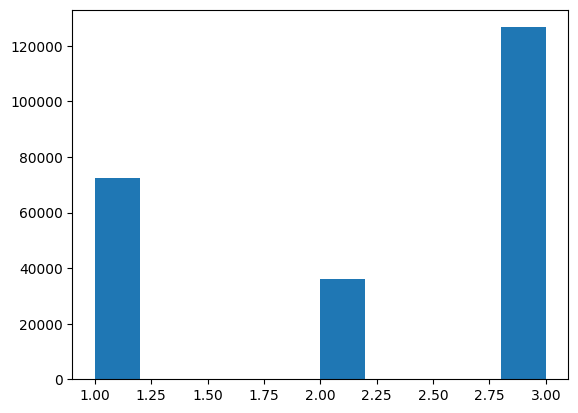

formal charge
(array([5]), array([235183]))


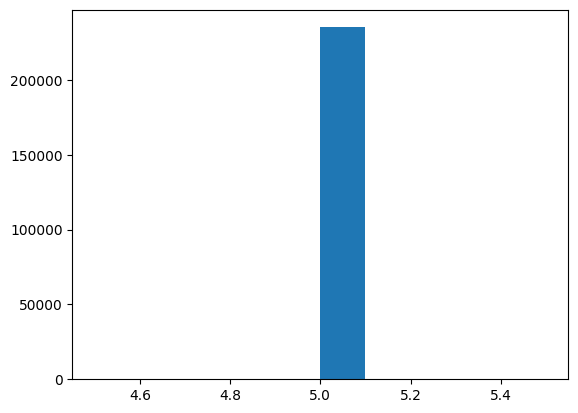

n hydrogens
(array([0, 1, 2]), array([199001,  18091,  18091]))


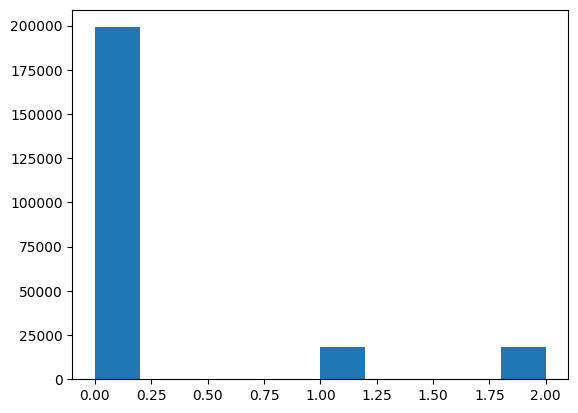

n radical electrons
(array([0]), array([235183]))


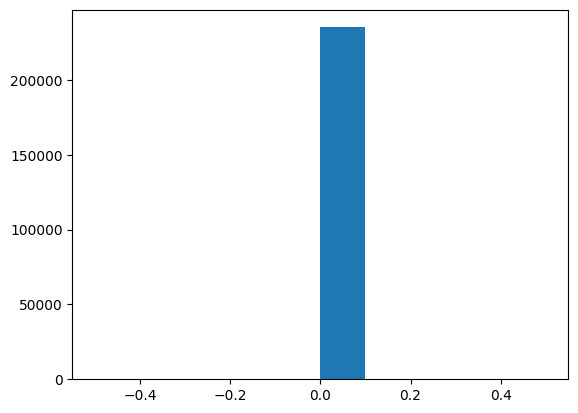

hybridization
(array([3, 4]), array([180910,  54273]))


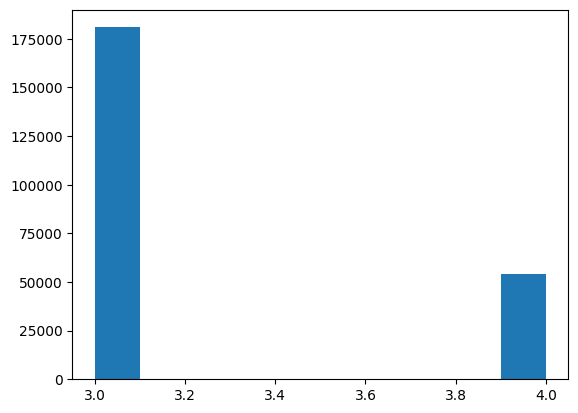

aromatic?
(array([0, 1]), array([126637, 108546]))


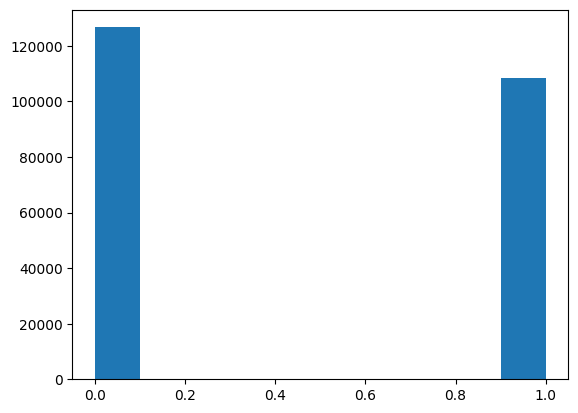

in ring?
(array([0, 1]), array([126637, 108546]))


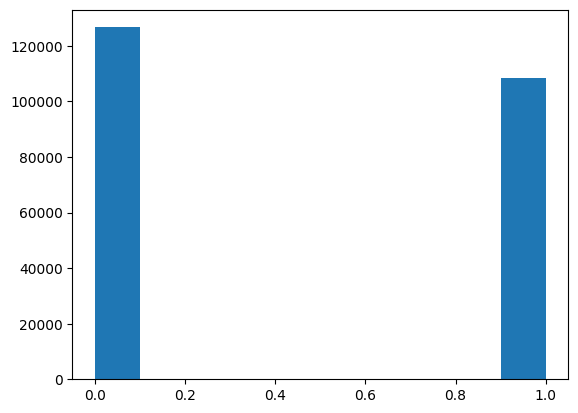

In [14]:
atom_feat_names = ['atomic n', 'chirality', 'degree', 'formal charge', 'n hydrogens', 'n radical electrons', 'hybridization', 'aromatic?', 'in ring?']

all_mol_atom_attr = np.concatenate(mol_atom_attrs)

for i, name in enumerate(atom_feat_names):
  print(name)
  print(np.unique(all_mol_atom_attr[:,i], return_counts=True))
  plt.hist(all_mol_atom_attr[:,i])
  plt.show()

# Notes: onehot encode atoms, all have chirality of 0 so drop, degree only 
# 1/2/3 so scale 0-1 (no quad bonded atoms???), formal charge always 5 so 
# drop, n hydrogens always 0/1/2 so scale 0-1, n radical electrons always 0,
# hybridization always 3 or 4, aromatic and in ring are onehot

Bond type
(array([ 1,  2, 12]), array([217092,  36182, 217092]))


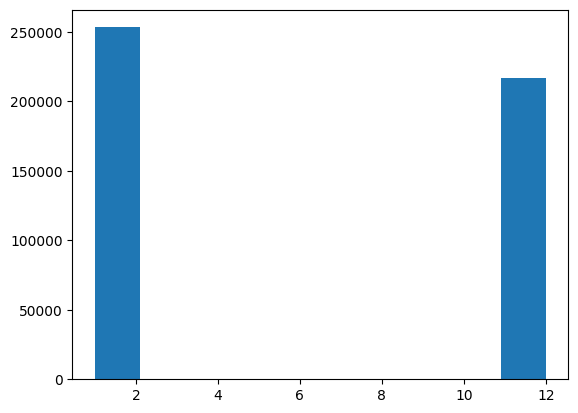

stereo
(array([0]), array([470366]))


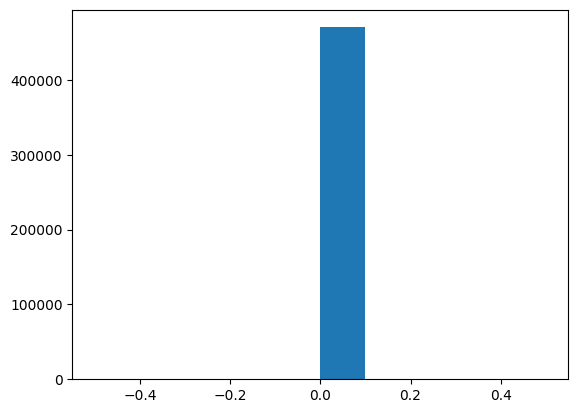

conjugated?
(array([0, 1]), array([108546, 361820]))


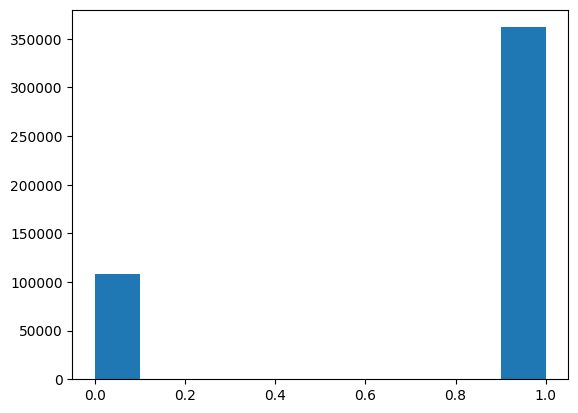

In [16]:
bond_feat_names = ['Bond type', 'stereo', 'conjugated?']

all_mol_bond_attr = np.concatenate(mol_bond_attrs)

for i, name in enumerate(bond_feat_names):
  print(name)
  print(np.unique(all_mol_bond_attr[:,i], return_counts=True))
  plt.hist(all_mol_bond_attr[:,i])
  plt.show()

  # Notes: dataset does not contain any triple bonds (???), bond and a half is
  # 12 so convert to 1.5, stereo always 0, conjugated is onehot